In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection

In [2]:
#import notebooks

In [4]:
combined_gdf = gpd.read_parquet('/data/processed_data/regression_stats')

In [5]:
combined_gdf

,ID,geometry,cluster,%german,Germany,Abroad,%german_lag,Germany_lag,Abroad_lag,%holidayapt,...,Under 30_lag,120 - 129_lag,100 - 109_lag,140 - 149_lag,150 - 159_lag,130 - 139_lag,160 - 169_lag,170 - 179_lag,morph_label,label
0,100mN27618E41614,"POLYGON ((4161500 2761900, 4161500 2761800, 41...",16.0,1.000000,12.0,NaN,0.750000,3.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
1,100mN27625E41613,"POLYGON ((4161400 2762600, 4161400 2762500, 41...",12.0,0.920000,69.0,6.0,0.935507,25.333333,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206,14
2,100mN27626E41613,"POLYGON ((4161400 2762700, 4161400 2762600, 41...",12.0,0.850000,51.0,9.0,0.960000,36.000000,NaN,0.0,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,206,14
3,100mN27628E41614,"POLYGON ((4161500 2762900, 4161500 2762800, 41...",12.0,0.947368,18.0,NaN,0.943333,7.400000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,13
4,100mN27628E41615,"POLYGON ((4161600 2762900, 4161600 2762800, 41...",12.0,1.000000,3.0,NaN,0.915789,12.666667,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,100mN27710E41605,"POLYGON ((4160600 2771100, 4160600 2771000, 41...",15.0,0.529412,9.0,8.0,0.800000,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,16
2115,100mN27710E41619,"POLYGON ((4162000 2771100, 4162000 2771000, 41...",13.0,1.000000,10.0,NaN,0.985915,70.000000,NaN,0.0,...,3.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,39,10
2116,100mN27710E41621,"POLYGON ((4162200 2771100, 4162200 2771000, 41...",13.0,1.000000,24.0,NaN,0.952554,80.500000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109,10
2117,100mN27711E41603,"POLYGON ((4160400 2771200, 4160400 2771100, 41...",15.0,0.909091,10.0,NaN,0.937500,5.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,16


In [31]:
# Assuming gdf is your GeoDataFrame
nan_percentage = combined_gdf.isna().mean() * 100

# Display the percentage of NaN values for each column
print(nan_percentage)

ID                 0.000000
geometry           0.000000
cluster            0.000000
%german            0.000000
Germany            0.000000
                    ...    
130 - 139_lag     99.716848
160 - 169_lag    100.000000
170 - 179_lag    100.000000
morph_label        0.000000
label              0.000000
Length: 128, dtype: float64


In [6]:
list(combined_gdf.columns)

['ID',
 'geometry',
 'cluster',
 '%german',
 'Germany',
 'Abroad',
 '%german_lag',
 'Germany_lag',
 'Abroad_lag',
 '%holidayapt',
 '%rented',
 'Rented: with currently managed household',
 'Ownership: with currently managed household',
 'Holiday and leisure apartment',
 'Vacant',
 'Ownership: without currently managed household',
 'Rented: without currently managed household',
 '%rented_lag',
 'Rented: with currently managed household_lag',
 'Ownership: with currently managed household_lag',
 'Holiday and leisure apartment_lag',
 'Vacant_lag',
 'Ownership: without currently managed household_lag',
 'Rented: without currently managed household_lag',
 'age',
 'Under 10',
 '20 - 29',
 '60 - 69_x',
 '10 - 19',
 '40 - 49_x',
 '50 - 59_x',
 '30 - 39_x',
 '70 - 79_x',
 '80 and older',
 'age_lag',
 'Under 10_lag',
 '20 - 29_lag',
 '60 - 69_lag_x',
 '10 - 19_lag',
 '40 - 49_lag_x',
 '50 - 59_lag_x',
 '30 - 39_lag_x',
 '70 - 79_lag_x',
 '80 and older_lag',
 'apartmentno',
 '1 apartment',
 '3 - 6 

# random forest

In [9]:
training_sample = combined_gdf.sample(2000, random_state=0)

In [10]:
independent_variables1 = [
    '%german',
 'Germany',
 'Abroad',
 '%german_lag',
 'Germany_lag',
 'Abroad_lag',
 '%holidayapt',
 '%rented',
 'Rented: with currently managed household',
 'Ownership: with currently managed household',
 'Holiday and leisure apartment',
 'Vacant',
 'Ownership: without currently managed household',
 'Rented: without currently managed household',
 '%rented_lag',
 'Rented: with currently managed household_lag',
 'Ownership: with currently managed household_lag',
 'Holiday and leisure apartment_lag',
 'Vacant_lag',
 'Ownership: without currently managed household_lag',
 'Rented: without currently managed household_lag',
 'age',
 'Under 10',
 '20 - 29',
 '60 - 69_x',
 '10 - 19',
 '40 - 49_x',
 '50 - 59_x',
 '30 - 39_x',
 '70 - 79_x',
 '80 and older',
 'age_lag',
 'Under 10_lag',
 '20 - 29_lag',
 '60 - 69_lag_x',
 '10 - 19_lag',
 '40 - 49_lag_x',
 '50 - 59_lag_x',
 '30 - 39_lag_x',
 '70 - 79_lag_x',
 '80 and older_lag',
 'apartmentno',
 '1 apartment',
 '3 - 6 apartments',
 '2 apartments',
 '7 - 12 apartments',
 '13 and more apartments',
 'apartmentno_lag',
 '1 apartment_lag',
 '3 - 6 apartments_lag',
 '2 apartments_lag',
 '7 - 12 apartments_lag',
 '13 and more apartments_lag',
 'buildingyear',
 '1919 - 1948',
 '1949 - 1978',
 '2001 - 2004',
 '1987 - 1990',
 '1996 - 2000',
 'Before 1919',
 '1979 - 1986',
 '2005 - 2008',
 '2009 and later',
 '1991 - 1995',
 'buildingyear_lag',
 '1919 - 1948_lag',
 '1949 - 1978_lag',
 '2001 - 2004_lag',
 '1987 - 1990_lag',
 '1996 - 2000_lag',
 'Before 1919_lag',
 '1979 - 1986_lag',
 '2005 - 2008_lag',
 '2009 and later_lag',
 '1991 - 1995_lag',
 'familysize',
 '2 people',
 '4 people',
 '5 people',
 '3 people',
 '6 or more people',
 'familysize_lag',
 '2 people_lag',
 '4 people_lag',
 '5 people_lag',
 '3 people_lag',
 '6 or more people_lag',
 'floorspace',
 '50 - 59_y',
 '60 - 69_y',
 '80 - 89',
 '70 - 79_y',
 '90 - 99',
 '110 - 119',
 '40 - 49_y',
 '180 and more',
 '30 - 39_y',
 'Under 30',
 '120 - 129',
 '100 - 109',
 '140 - 149',
 '150 - 159',
 '130 - 139',
 '160 - 169',
 '170 - 179',
 'floorspace_lag',
 '50 - 59_lag_y',
 '60 - 69_lag_y',
 '80 - 89_lag',
 '70 - 79_lag_y',
 '90 - 99_lag',
 '110 - 119_lag',
 '40 - 49_lag_y',
 '180 and more_lag',
 '30 - 39_lag_y',
 'Under 30_lag',
 '120 - 129_lag',
 '100 - 109_lag',
 '140 - 149_lag',
 '150 - 159_lag',
 '130 - 139_lag',
 '160 - 169_lag',
 '170 - 179_lag'
]

In [40]:
independent_variables = ['Germany',
 'Abroad',
 'Germany_lag',
 'Abroad_lag',
 'Rented: with currently managed household',
 'Ownership: with currently managed household',
 'Holiday and leisure apartment',
 'Vacant',
 'Ownership: without currently managed household',
 'Rented: without currently managed household',
 'Rented: with currently managed household_lag',
 'Ownership: with currently managed household_lag',
 'Holiday and leisure apartment_lag',
 'Vacant_lag',
 'Ownership: without currently managed household_lag',
 'Rented: without currently managed household_lag',
 'Under 10',
 '20 - 29',
 '60 - 69_x',
 '10 - 19',
 '40 - 49_x',
 '50 - 59_x',
 '30 - 39_x',
 '70 - 79_x',
 '80 and older',
 'Under 10_lag',
 '20 - 29_lag',
 '60 - 69_lag_x',
 '10 - 19_lag',
 '40 - 49_lag_x',
 '50 - 59_lag_x',
 '30 - 39_lag_x',
 '70 - 79_lag_x',
 '80 and older_lag',
 '1 apartment',
 '3 - 6 apartments',
 '2 apartments',
 '7 - 12 apartments',
 '13 and more apartments',
 '1 apartment_lag',
 '3 - 6 apartments_lag',
 '2 apartments_lag',
 '7 - 12 apartments_lag',
 '13 and more apartments_lag',
 '1919 - 1948',
 '1949 - 1978',
 '2001 - 2004',
 '1987 - 1990',
 '1996 - 2000',
 'Before 1919',
 '1979 - 1986',
 '2005 - 2008',
 '2009 and later',
 '1991 - 1995',
 '1919 - 1948_lag',
 '1949 - 1978_lag',
 '2001 - 2004_lag',
 '1987 - 1990_lag',
 '1996 - 2000_lag',
 'Before 1919_lag',
 '1979 - 1986_lag',
 '2005 - 2008_lag',
 '2009 and later_lag',
 '1991 - 1995_lag',
 '2 people',
 '4 people',
 '5 people',
 '3 people',
 '6 or more people',
 '2 people_lag',
 '4 people_lag',
 '5 people_lag',
 '3 people_lag',
 '6 or more people_lag',
 '50 - 59_y',
 '60 - 69_y',
 '80 - 89',
 '70 - 79_y',
 '90 - 99',
 '110 - 119',
 '40 - 49_y',
 '180 and more',
 '30 - 39_y',
 'Under 30',
 '120 - 129',
 '100 - 109',
 '140 - 149',
 '150 - 159',
 '130 - 139',
 '160 - 169',
 '170 - 179',
 '50 - 59_lag_y',
 '60 - 69_lag_y',
 '80 - 89_lag',
 '70 - 79_lag_y',
 '90 - 99_lag',
 '110 - 119_lag',
 '40 - 49_lag_y',
 '180 and more_lag',
 '30 - 39_lag_y',
 'Under 30_lag',
 '120 - 129_lag',
 '100 - 109_lag',
 '140 - 149_lag',
 '150 - 159_lag',
 '130 - 139_lag',
 '160 - 169_lag',
 '170 - 179_lag'
]

In [42]:
independent = training_sample[independent_variables]
independent

,Germany,Abroad,Germany_lag,Abroad_lag,Rented: with currently managed household,Ownership: with currently managed household,Holiday and leisure apartment,Vacant,Ownership: without currently managed household,Rented: without currently managed household,...,180 and more_lag,30 - 39_lag_y,Under 30_lag,120 - 129_lag,100 - 109_lag,140 - 149_lag,150 - 159_lag,130 - 139_lag,160 - 169_lag,170 - 179_lag
1986,46.0,NaN,40.714286,NaN,7.0,14.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,282.0,152.0,142.428571,NaN,148.0,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1734,4.0,NaN,18.833333,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,37.0,3.0,60.875000,8.0,6.0,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,30.0,3.0,131.142857,NaN,3.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,105.0,17.0,117.800000,25.2,53.0,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,33.0,3.0,58.375000,NaN,18.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1613,84.0,8.0,77.857143,NaN,24.0,24.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,88.0,8.0,64.000000,NaN,27.0,31.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(independent, training_sample["label"], test_size=0.25, random_state=0)

In [44]:
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [45]:
pred = model.predict(X_test)
pred

array([14, 16,  5, 16, 11,  8, 10,  7,  5, 10, 10, 10,  4,  4, 14, 13, 10,
       14, 12,  6, 13, 14, 10, 10,  5, 13, 12,  6,  4, 10,  5,  6, 10,  6,
       13, 14,  4, 12,  4, 11,  4, 10, 10,  4, 12,  5,  4,  8,  7, 14, 10,
        7, 10, 14,  4, 14, 10, 14, 14, 14,  6, 12,  9, 13,  1, 14, 10, 10,
       10,  6,  4, 10, 12,  4, 10, 14,  7,  4, 10, 10, 16,  4, 14, 13, 10,
        5, 14, 11,  4,  5, 14, 10,  7,  4,  4,  5, 11,  7, 13, 10, 10,  4,
        4, 10, 14, 11, 10,  4, 10, 14, 14, 11,  5,  7,  4,  5, 14, 12, 14,
        6, 12, 10,  5,  4, 12,  4,  5,  4, 10,  4, 12,  4, 14, 10,  5,  4,
        7, 12, 12, 10, 14, 13, 10, 10,  5,  5, 10, 13,  4,  4, 10, 14,  4,
       14, 10,  5, 14, 10, 10,  5,  4, 11, 10,  7,  7, 12, 10,  4, 12, 14,
        5, 10, 14, 13, 14, 10,  6, 10, 10, 12, 14,  4,  7, 10,  8,  7, 13,
        5, 10, 10, 10, 10, 11,  4,  5, 12, 10,  6,  5, 10,  7,  7, 12, 12,
       12, 10, 14,  4, 13, 10,  6,  7, 10, 11, 14, 10,  5, 10,  3, 14, 13,
       10, 14,  4, 14, 14

In [46]:
y_test

1210    10
2053    13
846      5
398     15
1308    12
        ..
1525    10
2103    10
1704    13
1408    16
975     15
Name: label, Length: 500, dtype: int32

In [47]:
proba = model.predict_proba(X_test)
proba

array([[0.  , 0.  , 0.  , ..., 0.43, 0.  , 0.06],
       [0.  , 0.02, 0.  , ..., 0.09, 0.  , 0.26],
       [0.  , 0.  , 0.  , ..., 0.02, 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.06, 0.  , 0.04],
       [0.  , 0.  , 0.  , ..., 0.36, 0.  , 0.06],
       [0.  , 0.  , 0.  , ..., 0.12, 0.  , 0.04]])

In [48]:
model.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [49]:
pd.DataFrame(proba, columns=model.classes_, index=X_test.index)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1210,0.00,0.00,0.00,0.05,0.03,0.14,0.05,0.00,0.02,0.10,0.11,0.01,0.00,0.43,0.00,0.06
2053,0.00,0.02,0.00,0.11,0.02,0.03,0.03,0.07,0.01,0.07,0.01,0.13,0.15,0.09,0.00,0.26
846,0.00,0.00,0.00,0.04,0.32,0.02,0.20,0.10,0.03,0.10,0.06,0.09,0.02,0.02,0.00,0.00
398,0.03,0.00,0.00,0.01,0.00,0.01,0.01,0.08,0.00,0.07,0.07,0.07,0.10,0.24,0.01,0.30
1308,0.00,0.00,0.00,0.07,0.15,0.00,0.16,0.09,0.02,0.12,0.20,0.03,0.01,0.09,0.02,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,0.00,0.00,0.01,0.01,0.07,0.07,0.04,0.02,0.01,0.35,0.16,0.00,0.00,0.22,0.00,0.04
2103,0.00,0.00,0.01,0.08,0.13,0.00,0.13,0.08,0.06,0.20,0.06,0.12,0.08,0.04,0.00,0.01
1704,0.00,0.00,0.00,0.01,0.06,0.00,0.01,0.07,0.01,0.05,0.08,0.19,0.42,0.06,0.00,0.04
1408,0.00,0.00,0.00,0.09,0.04,0.24,0.01,0.01,0.00,0.08,0.07,0.03,0.01,0.36,0.00,0.06


In [50]:
accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.434
  Kappa:    0.363



In [51]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

170 - 179_lag                                      0.000000
160 - 169_lag                                      0.000000
1987 - 1990_lag                                    0.000000
2005 - 2008_lag                                    0.000000
2009 and later_lag                                 0.000000
                                                     ...   
Ownership: with currently managed household_lag    0.032608
Germany                                            0.032724
2 people_lag                                       0.035635
Rented: with currently managed household_lag       0.040813
Germany_lag                                        0.053509
Length: 108, dtype: float64

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


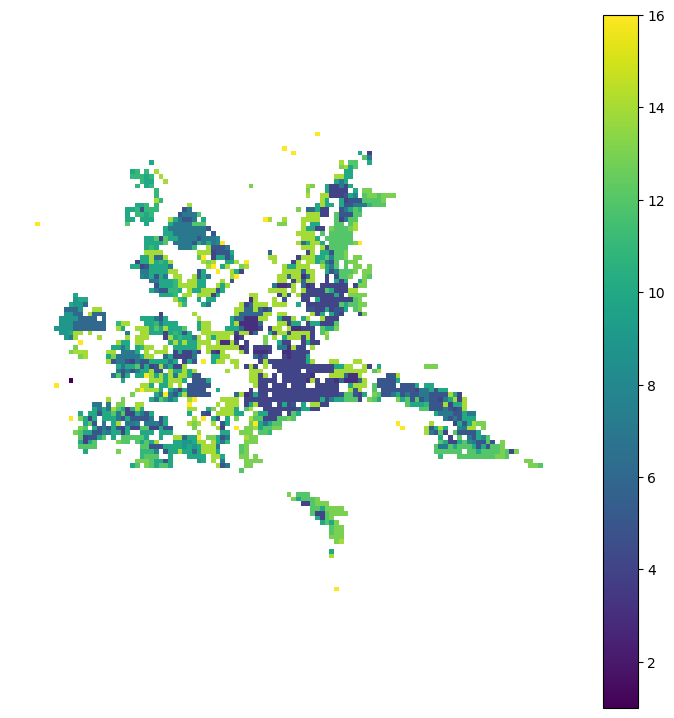

In [52]:
predicted = model_selection.cross_val_predict(
    model, independent, training_sample["label"], cv=4, n_jobs=-1
)

ax = training_sample.plot(predicted, legend=True, figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

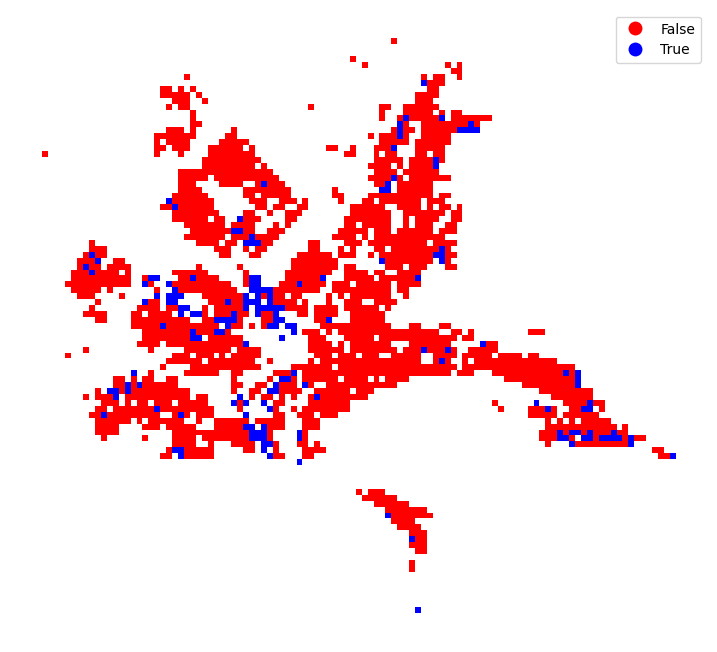

In [53]:
ax = training_sample.plot(
    predicted == training_sample["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.1,
    cmap="bwr_r",
    legend=True,
)
ax.set_axis_off()

In [54]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    training_sample,
    training_sample.label,
    groups=training_sample.morph_label,
)

In [55]:
gkf

StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False)

In [56]:
split_label = np.empty(len(training_sample), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i
training_sample["split"] = split_label


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


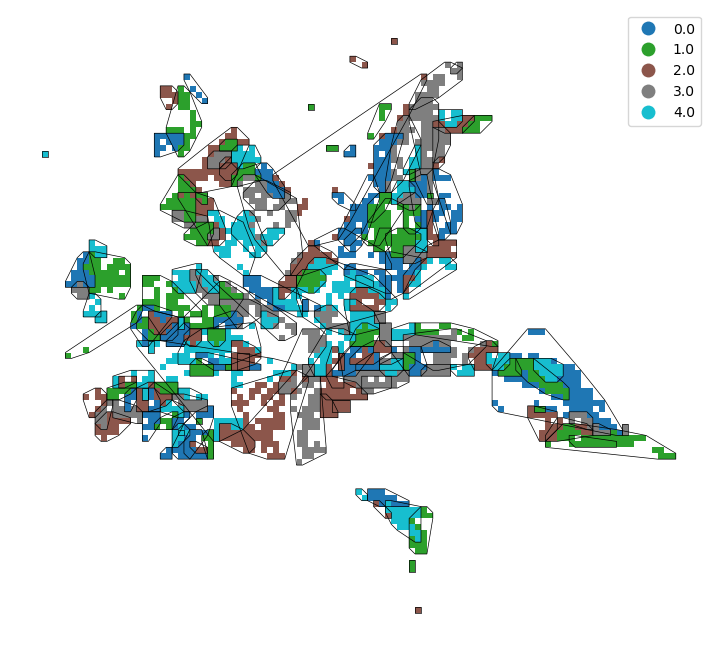

In [57]:
ax = training_sample.plot(
  "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
)
training_sample.dissolve("morph_label").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.5, markersize=0
)
ax.set_axis_off()

In [58]:
train = training_sample["split"] != 0
X_train = independent.loc[train]
y_train = training_sample["label"].loc[train]

test = training_sample["split"] == 0
X_test = independent.loc[test]
y_test = training_sample["label"].loc[test]

In [59]:
rf_spatial_cv = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_spatial_cv.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [60]:
# raw data with lag

In [61]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.434
  Kappa:    0.363
Basic model with spatial cross-validation:
  Accuracy: 0.347
  Kappa:    0.267



In [62]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

170 - 179_lag                                      0.000000
160 - 169_lag                                      0.000000
1987 - 1990_lag                                    0.000000
2005 - 2008_lag                                    0.000000
2009 and later_lag                                 0.000000
                                                     ...   
Ownership: with currently managed household_lag    0.032608
Germany                                            0.032724
2 people_lag                                       0.035635
Rented: with currently managed household_lag       0.040813
Germany_lag                                        0.053509
Length: 108, dtype: float64

In [63]:
# raw data with averaged indicies and lag

In [30]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.46
  Kappa:    0.392
Basic model with spatial cross-validation:
  Accuracy: 0.372
  Kappa:    0.297



In [69]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

familysize          0.052381
%german             0.053775
%rented             0.055094
age                 0.057134
floorspace          0.063505
apartmentno         0.067067
familysize_lag      0.072597
floorspace_lag      0.074299
buildingyear        0.074330
%german_lag         0.074721
%rented_lag         0.081275
age_lag             0.085001
apartmentno_lag     0.088150
buildingyear_lag    0.100671
dtype: float64